In [1]:

from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr
import gcsfs
import datetime
import os
import numpy as np

## Dipole Mode Index (DMI)

https://psl.noaa.gov/gcos_wgsp/Timeseries/DMI/

Intensity of the IOD is represented by anomalous SST gradient between the western equatorial Indian Ocean (50E-70E and 10S-10N) and the south eastern equatorial Indian Ocean (90E-110E and 10S-0N). This gradient is named as Dipole Mode Index (DMI). When the DMI is positive then, the phenomenon is refereed as the positive IOD and when it is negative, it is refereed as negative IOD.

As the original provider has changed how they update the index, we have decided to calculate it here using the HadISST1.1 SST dataset for the entire time period. Climatology is currently 1981-2010.

## Create DMI Index

In [2]:
url='https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/dmi.had.long.data'
#file='nao.data'
#index_name='nao'

df=pd.read_table(url,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-9999.000'])
df.drop(df.tail(7).index,inplace=True)

In [3]:
df

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
1870,-0.438,-0.336,0.177,-0.048,-0.480,-0.548,-0.650,-0.522,-0.728,-0.636,-0.401,-0.375
1871,-0.273,-0.170,-0.212,-0.148,-0.115,-0.163,-0.444,-0.375,-0.336,-0.527,-0.217,-0.228
1872,-0.037,0.041,-0.076,-0.084,-0.148,-0.084,-0.285,-0.325,-0.333,-0.270,-0.106,-0.111
1873,0.062,-0.319,-0.404,-0.272,-0.411,-0.587,-0.689,-0.800,-0.694,-0.479,-0.353,-0.303
1874,-0.381,-0.388,-0.586,-0.754,-0.441,-0.465,-0.338,-0.345,-0.814,-1.158,-0.603,-0.790
...,...,...,...,...,...,...,...,...,...,...,...,...
2019,0.387,0.416,0.224,0.258,0.539,0.605,0.597,0.436,0.893,0.964,0.835,0.243
2020,0.173,0.054,0.019,-0.011,0.298,0.454,0.320,-0.183,-0.190,0.074,0.020,0.030
2021,0.051,0.243,0.266,0.250,0.009,-0.002,-0.228,-0.099,-0.058,-0.091,0.069,-0.120


In [4]:
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-01'
print(start_date)

1870-1-01


In [5]:
dates=pd.date_range(start=start_date,end=end_date,freq='MS')

In [6]:
clim_index=df.T.unstack().values
clim_index=clim_index.astype('float32')

In [7]:
ds_index=xr.DataArray(clim_index,
                      coords={'time':dates},
                              dims=['time'])        
ds_index=ds_index.to_dataset(name='sst')
#ds_index

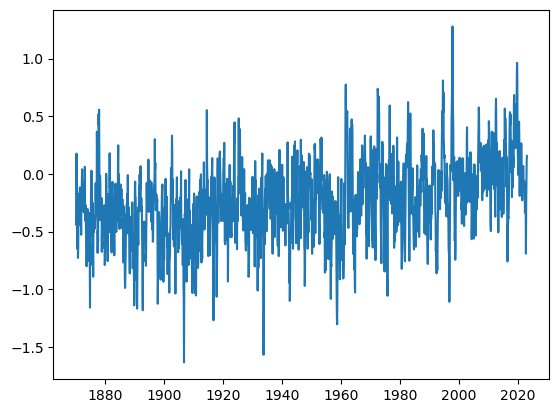

In [8]:
plt.plot(ds_index['time'],ds_index['sst'])

The IOD is a key driver of such interannual rainfall variability, describing differences in sea surface temperature (SST) anomaly between the western (50° E to 70° E, 10° S to 10° N) and eastern (90° E to 110° E, 10° S to 0° S) Indian Ocean. The positive IOD (signifying an SST anomaly difference of at least +0.4 °C for at least three months between the warmer west and cooler east) is linked with wetter short rains over Eastern Africa (Fig. 2a). During such phases, precipitation totals can be 2–3 times the long-term mean16, as seen in 1997, 2006, 2012, 2015 and 2019. In contrast, the negative IOD (defined by a sustained negative SST difference of at least 0.4 °C) is associated with weaker short rains17, resulting in 20–60% of the long-term mean rainfall, as evident during 1996, 1998, 2010 and 2016 (Fig. 2b).

https://www.nature.com/articles/s43017-023-00397-x#:~:text=Rainfall%20variability%20over%20Eastern%20Africa,%E2%80%93Julian%20Oscillation%20(MJO).

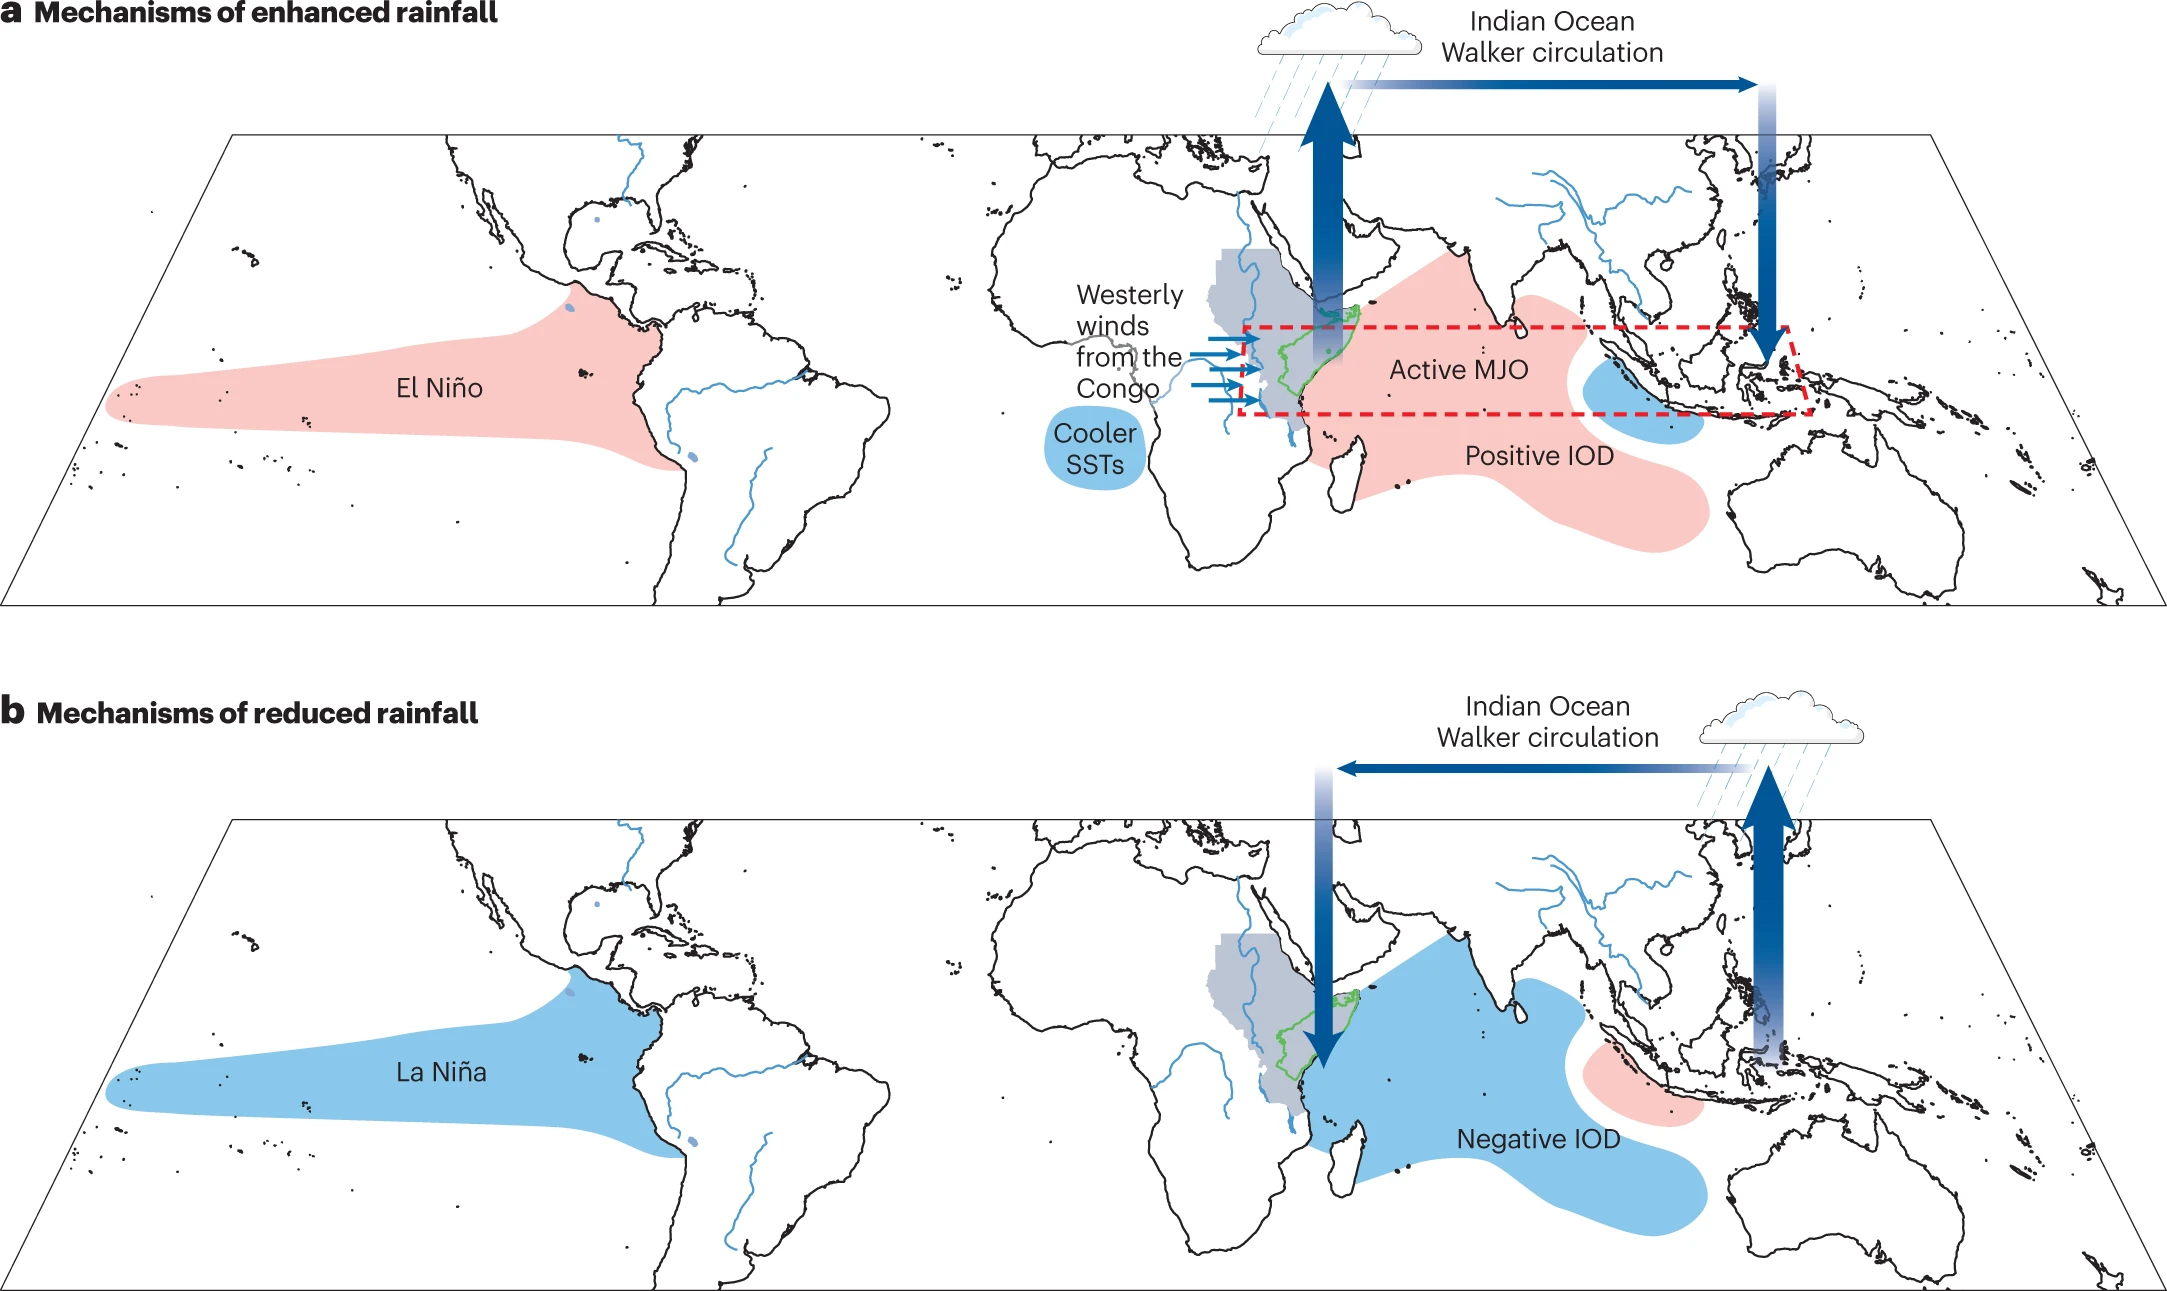

In [9]:
from PIL import Image
import requests
from io import BytesIO

url = "https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs43017-023-00397-x/MediaObjects/43017_2023_397_Fig2_HTML.png?as=webp"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.show()

pos IOD:  19
Neutral:  290
negative IOD:  51
[array(19), array(51), array(290)]


Text(0.5, 1.0, 'DMI 1981-2010; IOD (Threshold = 0.4 $\\degree$C)')

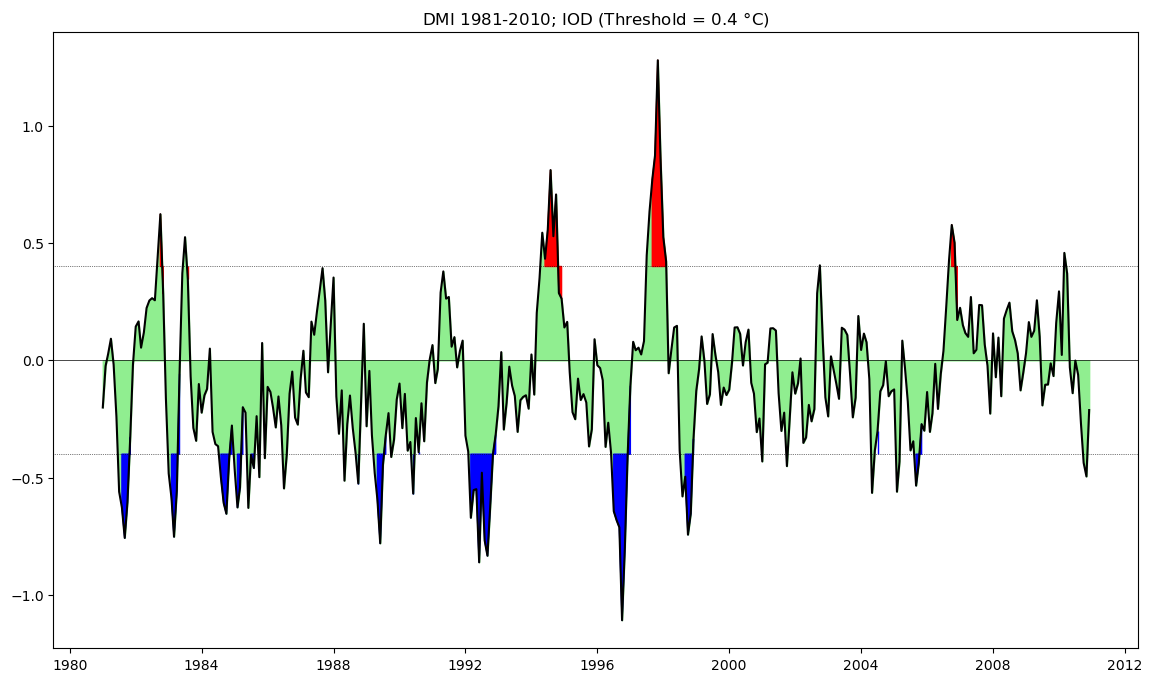

In [10]:
pos_iod=ds_index.sst.sel(time=slice('1981', '2010')).where(ds_index.sst.rolling(time=3).mean()>= 0.4)
neg_iod=ds_index.sst.sel(time=slice('1981', '2010')).where(ds_index.sst.rolling(time=3).mean() <= -0.4)
neutral=ds_index.sst.sel(time=slice('1981', '2010')).where(np.logical_and(ds_index.sst.rolling(time=3).mean()>-.4,
                                              ds_index.sst.rolling(time=3).mean()<.4))

print('pos IOD: ',pos_iod.count(dim='time').values)
print('Neutral: ',neutral.count(dim='time').values)
print('negative IOD: ',neg_iod.count(dim='time').values)

counts=[pos_iod.count(dim='time').values,
        neg_iod.count(dim='time').values,
        neutral.count(dim='time').values]
print(counts)
fig = plt.figure(figsize=(14, 8))
plt.plot(ds_index.time.sel(time=slice('1981', '2010')),ds_index.sst.sel(time=slice('1981', '2010')),'k')
plt.fill_between(ds_index.time.sel(time=slice('1981', '2010')).values,ds_index.sst.sel(time=slice('1981', '2010')),color='lightgreen')
plt.fill_between(ds_index.time.sel(time=slice('1981', '2010')).values,pos_iod,y2=.4,color='red')
plt.fill_between(ds_index.time.sel(time=slice('1981', '2010')).values,neg_iod,y2=-.4,color='blue')
plt.axhline(0,color='black',linewidth=0.5)
plt.axhline(.4,color='black',linewidth=0.5,linestyle='dotted')
plt.axhline(-.4,color='black',linewidth=0.5,linestyle='dotted') ;#ds_index

plt.title('DMI 1981-2010; IOD (Threshold = 0.4 $\degree$C)')

In [11]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_historical = df.query("table_id == 'Amon' & " +\
    "variable_id == 'pr' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
print('Length of df_historical:', len(df_historical))
df_historical.head(3)

Length of df_historical: 54


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
6263,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
28995,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Amon,pr,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
32443,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827


In [ ]:
Create Composite DMI and CMIP6 FDF

In [12]:
model = 'GFDL-CM4'

zstore_hist = df_historical.query(f"source_id == '{model}'").zstore.values[0]

In [13]:
gcs = gcsfs.GCSFileSystem(token='anon')
mapper = gcs.get_mapper(zstore_hist)
ds_hist= xr.open_zarr(mapper, consolidated = True)

# Convert to DATETIME
time coordinate is in "object" format, which we need to convert to datetime to be able to easily analyze the timeseries.

In [14]:
print('historical date range:', ds_hist.time[0].values, ' , ', ds_hist.time[-1].values) #first date end date

historical date range: 1850-01-16 12:00:00  ,  2014-12-16 12:00:00


In [15]:
start_time = pd.to_datetime(datetime.date(1850,1,1)) #set start date
time_new_ds_hist = [start_time + pd.DateOffset(months = x) for x in range(len(ds_hist.time))] #convert to date time

In [16]:
ds_hist = ds_hist.assign_coords(time = time_new_ds_hist) #assign converted datetime to dataset

In [17]:
da_precip = ds_hist.pr.sel(time=slice(ds_index.time.sel(time=slice('1981', '2010'))['time'][0],ds_index.time.sel(time=slice('1981', '2010'))['time'][-1]))

da_climo = da_precip.groupby('time.month').mean()
da_anoms = da_precip.groupby('time.month')-da_climo
#da_anoms

/home/lcarte2/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 30 times more chunks
  return self.array[key]


## convert Precip to mm/day

In [18]:
da_anoms = da_anoms * 86400

In [19]:
posIOD_precip = da_anoms.sel(time=pos_iod.dropna(dim='time')['time'], method='nearest').mean(dim='time')
negIOD_precip = da_anoms.sel(time=neg_iod.dropna(dim='time')['time'], method='nearest').mean(dim='time')
neutralIOD_precip = da_anoms.sel(time=neutral.dropna(dim='time')['time'], method='nearest').mean(dim='time')

comp_precip = [posIOD_precip,negIOD_precip,neutralIOD_precip]


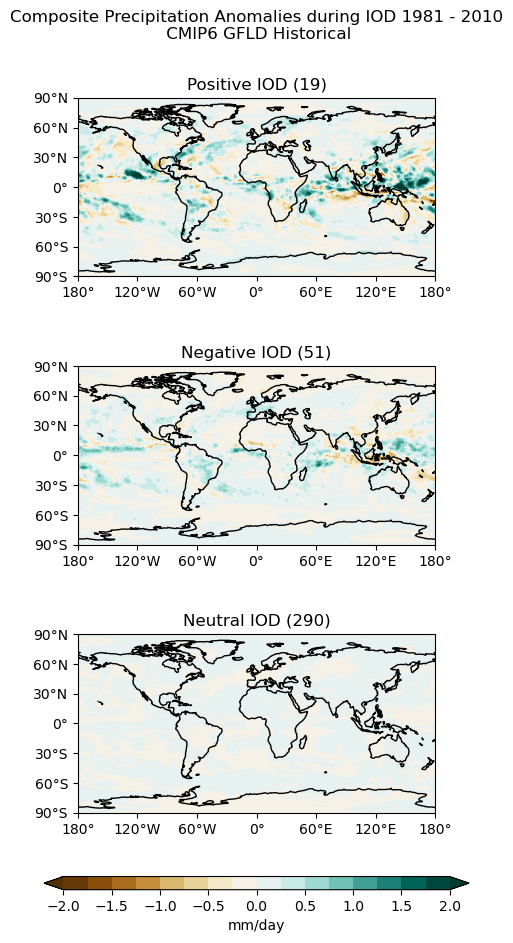

In [20]:
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

labels=['Positive IOD','Negative IOD', 'Neutral IOD']
clevs = np.arange(-2.0,2.1,0.25)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,enso in enumerate(comp_precip):

        # Select the season
        data = comp_precip[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=comp_precip[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_precip[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i]+' ('+str(counts[i])+')')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')

# Add a big title at the top
plt.suptitle('Composite Precipitation Anomalies during IOD 1981 - 2010\n CMIP6 GFLD Historical') ;

In [21]:
diff_precip=[posIOD_precip-neutralIOD_precip, 
             negIOD_precip-neutralIOD_precip]

Text(0.5, 0.98, 'Composite Precipitation Differences during ENSO')

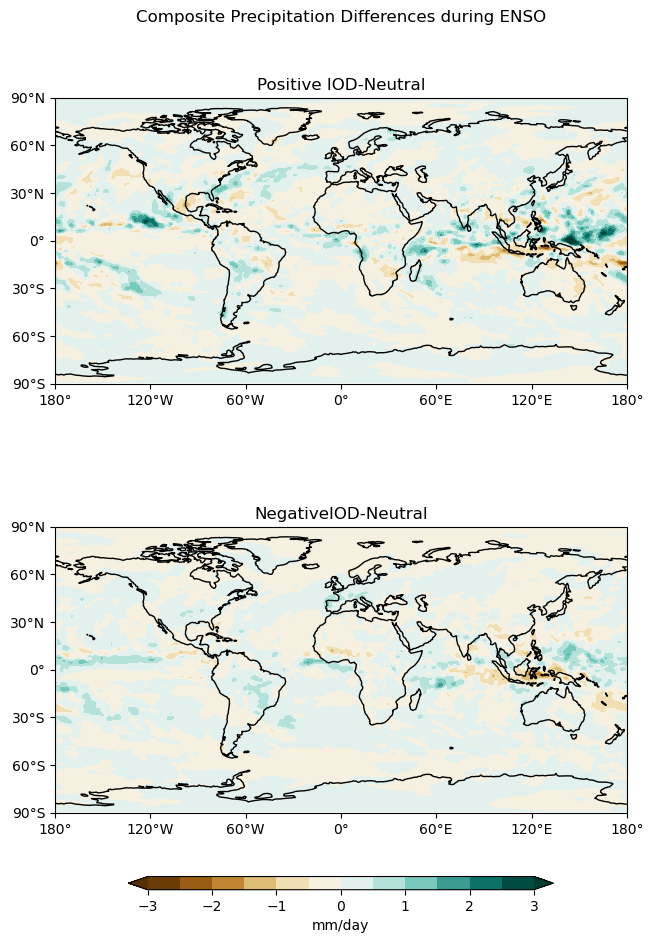

In [22]:
labels=['Positive IOD-Neutral','NegativeIOD-Neutral']
clevs=np.arange(-3,3.5,0.5)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,enso in enumerate(diff_precip):

        # Select the season
        data = diff_precip[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=diff_precip[i]['lon'])

        # Contour plot
        cs = axs[i].contourf(lons,diff_precip[i]['lat'],data,clevs,
                          transform=ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm/day')

# Add a big title at the top
plt.suptitle('Composite Precipitation Differences during ENSO')